In [11]:
from hnn_core import simulate_dipole, MPIBackend, pick_connection, law_2021_model, calcium_model
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
from utils import add_supra_beta_drives, rescale_pyr_morph, add_law_beta_drives, rescale_pyr_mech
import seaborn as sns
sns.set()
sns.set_style("whitegrid")


In [13]:
net = calcium_model()
net.connectivity

[L2_pyramidal -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'nmda'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ,
 L2_pyramidal -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'ampa'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ,
 L5_pyramidal -> L5_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'nmda'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ,
 L5_pyramidal -> L5_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'ampa'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ,
 L2_basket -> L2_pyramidal
 cell counts: 35 srcs, 100 targets
 connection probability: 1.0 
 loc: 'soma'; receptor: 'gabaa'
 weight: 0.05; delay: 1.0; lamtha: 50.0
  ,
 L2_basket -> L2_pyramidal
 cell counts: 35 srcs, 100 targets
 connection probability: 1.0 
 loc: 'soma'; receptor: 'gabab'
 wei

In [2]:
net_orig = law_2021_model()
add_law_beta_drives(net_orig, beta_start=200, strength=2.0)



<Network | 10 x 10 Pyramidal cells (L2, L5)
35 L2 basket cells
35 L5 basket cells>

In [3]:
dpl_L2IN_list = list()
net_L2IN_list = list()

conn_list = pick_connection(net_orig, src_gids='L2_basket', target_gids='L5_pyramidal')
inh_scale = [0.1, 1.0, 10.0]
for scale in inh_scale:
    net = net_orig.copy()
    for conn_idx in conn_list:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= scale

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

    dpl_L2IN_list.append(dpl)
    net_L2IN_list.append(net)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

No handles with labels found to put in legend.


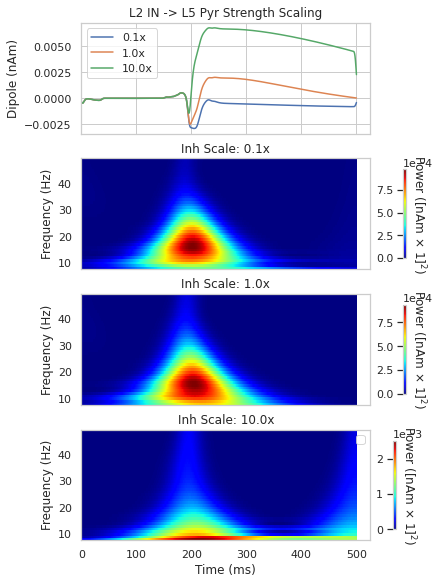

In [6]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale) in enumerate(zip(dpl_L2IN_list, inh_scale)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+1], show=False, colormap='jet')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')

axes[0].set_title('L2 IN -> L5 Pyr Strength Scaling')
axes[0].legend()
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()
#plt.savefig('u19_page2_figures/law_l2inh_l5_pyr_strength_sweep.png')

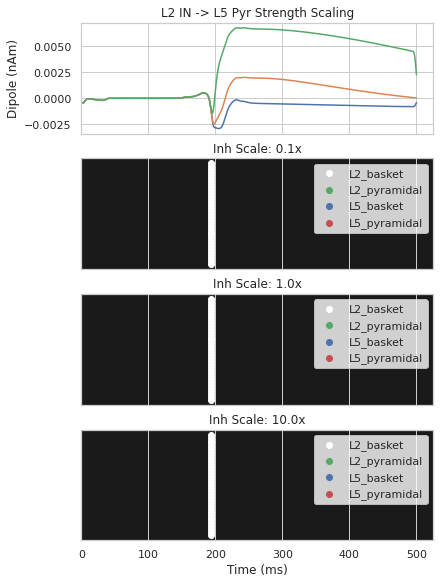

In [5]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale, net) in enumerate(zip(dpl_L2IN_list, inh_scale, net_L2IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx+1].set_title(f'Inh Scale: {scale}x')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+1], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('L2 IN -> L5 Pyr Strength Scaling')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.legend()
#plt.savefig('u19_page2_figures/law_l2inh_l5_pyr_strength_sweep.png')